## Project Description:

This notebook focuses on predictive maintenance in industrial settings using machine learning techniques. The objective is to develop a binary classification model capable of predicting machine failures. Leveraging various features such as temperature, rotational speed, torque, and tool wear, the model aims to accurately classify whether a machine is likely to experience failure or not. By employing advanced algorithms and robust evaluation methodologies, the notebook seeks to provide actionable insights for proactive maintenance strategies, ultimately enhancing operational efficiency and reducing downtime in industrial processes.

## Project Objective:

The primary goal of this notebook is to develop a robust binary classification model for predictive maintenance. The model will leverage historical data on machine performance and failure events to predict whether a machine is likely to fail in the future.

Data Preprocessing: Prepare the dataset by cleaning, transforming, and encoding features to ensure compatibility with machine learning algorithms.

Feature Engineering: Extract meaningful features and engineer new ones to capture important patterns and relationships in the data, enhancing predictive performance.

`Model Training: Implement and fine-tune various machine learning algorithms, including logistic regression, random forest, and gradient boosting, to develop a predictive binary classification model.`

`Model Evaluation: Evaluate the performance of the trained models using appropriate metrics such as accuracy, precision, recall, F1 score, and ROC AUC score. Employ cross-validation techniques to ensure robustness and generalization.`

Model Deployment: Deploy the best-performing model to production or integrate it into existing systems for real-time prediction of machine failures. Provide recommendations for proactive maintenance actions based on model insights.

By achieving these objectives, the notebook aims to empower industrial stakeholders with predictive analytics capabilities, enabling them to anticipate and mitigate potential machine failures, optimize maintenance schedules, and improve overall operational efficiency.

In [2]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, fbeta_score, recall_score, precision_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import sys
# sys.path.append(r'C:\Users\USER\Documents\Python Scripts\Machine learning\Neural networks\Predictive Maintenance\predictive-maintenance-supervised-learning\scripts')
#   # Add the directory containing training and evaluation scripts to Python path

# from model_training import fit_models, tune_and_fit
# from  model_evaluation import eval_preds,  predict_and_evaluate

In [4]:
# Load processed data for model training and evaluation(binary)

import joblib

# Load resampled data for Machine Failure
X_res_mf, y_res_mf = joblib.load(r'C:\Users\USER\Documents\Python Scripts\Machine learning\Neural networks\Predictive Maintenance\predictive-maintenance-supervised-learning\data\resampled_machine_failure.pkl')


## Binary task ¶

###  Preliminaries 

The goal of this section is to find the best model for binary classification of the dataset to predict whether or not there will be Machine Failure. Classification algorithms are part of data mining and use supervised machine learning methods to make predictions about data. In particular, a set of data already divided (”labeled”) into two or more classes of belonging is provided as input thanks to which a classification model is created, which will than be used on new (”unlabeled”) data to assign them to the appropriate class. The starting dataset is usually divided into three groups: the training dataset, i.e. the sample of data used to fit the model, the validation dataset, i.e. the sample of data used to provide an evaluation of a model fit on the training dataset while tuning model hyperparameters and the test dataset, which has the purpose of testing the model. At the beginning of a project a data scientist must make this division and the common ratios used are:

70% train, 15% val, 15% test.

80% train, 10% val, 10% test.

60% train, 20% val, 20% test.

In this project we use the ratio (80/10/10) for the split because we test the model for all of these strategies and find that it is the best one. The classification techniques we choose to implement are the following:

- Logistic Regression: it estimates the probability of a dependent variable as a function of independent variables. The dependent variable is the output that we are trying to predict while the independent variables or explanatory variables are the factors that we feel could influence the output. For its simplicity and interpretability, we decide to use Logistic Regression as a Benchmark model, a basic model that represents the starting point
for comparing the results obtained from other models.

- K-nearest neighbors (K-NN): algorithm based on the calculation of the distance between the elements of the dataset. Data is assigned to a certain class if close enough to the other data of the same class. Parameter K represents the number of neighboring data taken into account when assigning classes.

- Support Vector Machine: its aim is to find a hyperplane in an N-dimensional space (N—the number of features) that distinctly classifies the data points while maximizing the margin distance, i.e. the distance between data points of both classes.
Random Forest: it uses ensemble learning, which is a technique that combines many classifiers to provide solutions to complex problems. Random Forest uses bagging technique: it constructs a multitude of decision trees in parallel, all with the same importance, and the output is the class selected by most trees.

- XGBoost: is a gradient-boosted decision tree (GBDT) machine learning library. A Gradient Boosting Decision Tree (GBDT) is a decision tree ensemble learning algorithm similar to Random Forest, from which differs because it uses a boosting technique: it iteratively trains an ensemble of shallow decision trees, with each iteration using the error residuals of the previous model to fit the next model. The final prediction is a weighted sum of all of the tree predictions.

In [5]:
# train-validation-test split
X, y = X_res_mf, y_res_mf
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval, random_state=0)

### Feature selection attempts 

Before going into the training of the models just mentioned we try to perform feature selection, exploiting the considerations  made about the correlation heatmap and the exploratory data analysis: just to remind, it was noticed that the features `"Process temperature"` and `"Air temperature"` are positively correlated, and `"Torque"` and `"Rotational speed"` are negatively correlated. From the feature selection we see from the information scores that the product between "Torque" and "Rotational speed" has more importance than them individually and same can be said about the importance of the product and difference of `"Process temperature"` and `"Air temperature"` compared to the individual features . For these reasons, completely deleting these columns seems to be a bad choice because important information can be lost but at the same time it is reasonable to see what happens if we combine them taken by pairs. Therefore we proceed to compare the results obtained by fitting the classification models without tuning any parameter on the following datasets:

- The original one (without new features)- Tthe one obtained by removing the "Process temperature" and "Air temperature" columns, replacing them with a column of their produc and differencet
- T
the one obtained by removing "Torque" and "Rotational speed", replacing them with a column of their product- Ca comation of ine the previous operations.

In [6]:
X_train

,Air temperature _K_,Process temperature _K_,Rotational speed _rpm_,Torque _Nm_,Tool wear _min_,temp_product,temp_difference,power_output
3829,1.198103,0.738714,1.901342,-1.553133,0.755412,1.037842,1.298989,-1.364125
335,-1.301338,-1.283370,1.171143,-1.412659,-1.569952,-1.332262,-0.698269,-1.438805
182,-0.951417,-1.215968,-1.097490,0.814846,-0.847204,-1.094564,-0.099092,0.450633
3757,1.148114,0.738714,-0.924695,1.306503,1.148210,1.007718,1.199126,1.257284
10002,1.318212,0.603908,-1.145407,1.133277,-1.097286,1.051612,1.738657,0.821230
...,...,...,...,...,...,...,...,...
10013,0.362873,0.264788,0.329172,-0.714577,1.658028,0.329803,0.332607,-0.755922
6922,0.348293,0.873520,-0.289255,-0.017960,-0.910051,0.583972,-0.598406,-0.076181
1737,-0.751461,-1.418176,0.563573,-0.690225,0.598293,-1.061903,0.599948,-0.556964
2591,-0.501517,-0.878954,-0.501068,-0.108264,-1.412833,-0.681217,0.300360,-0.352612


In [7]:
#model_training.py
def fit_models(clf, clf_str, X_train, X_val, y_train, y_val):
    metrics = pd.DataFrame(columns=clf_str)
    for model, model_name in zip(clf, clf_str):
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        metrics[model_name] = eval_preds(model, X_val, y_val, y_val_pred, 'binary')[1]
    return metrics

def tune_and_fit(clf, X, y, params, task):
    if task == 'binary':
        f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params, cv=5, scoring=f2_scorer)
        grid_model.fit(X, y)
    elif task == 'multi_class':
        f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params, cv=5, scoring=f2_scorer)
        grid_model.fit(X, y)

    print('Best params:', grid_model.best_params_)
    # Print training times
    train_time = time.time()-start_time
    mins = int(train_time//60)
    print('Training time: '+str(mins)+'m '+str(round(train_time-mins*60))+'s')
    return grid_model


In [8]:
#model_evaluation.py
def eval_preds(model, X, y_true, y_pred, task):
    if task == 'binary':
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)[:,1]
        acc = accuracy_score(y_true, y_pred)  # Calculate accuracy
        auc = roc_auc_score(y_true, proba)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
    elif task == 'multi_class':
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)
        acc = accuracy_score(y_true, y_pred)  # Calculate accuracy
        auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
    metrics = pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1, 'F2':f2, 'Recall': recall, 'Precision': precision})
    metrics = round(metrics,3)
    return cm, metrics  # Return confusion matrix and metrics


def predict_and_evaluate(fitted_models, X, y_true, clf_str, task):
    cm_dict = {key: np.nan for key in clf_str}
    metrics = pd.DataFrame(columns=['ACC', 'AUC', 'F1', 'F2', 'Recall', 'Precision'])
    y_pred = pd.DataFrame(columns=clf_str)
    for fit_model, model_name in zip(fitted_models, clf_str):
        y_pred[model_name] = fit_model.predict(X)
        if task == 'binary':
            cm, scores = eval_preds(fit_model, X, y_true, y_pred[model_name], task)
        elif task == 'multi_class':
            cm, scores = eval_preds(fit_model, X, y_true, y_pred[model_name], task)
        cm_dict[model_name] = cm
        metrics.loc[model_name] = scores
    return y_pred, cm_dict, metrics

In [9]:
# Iterate over column names
for column_name in X_train.columns:
    # Check if the column name contains any of the restricted characters
    if '[' in column_name or ']' in column_name or '<' in column_name:
        print(f"Column name '{column_name}' contains invalid characters.")

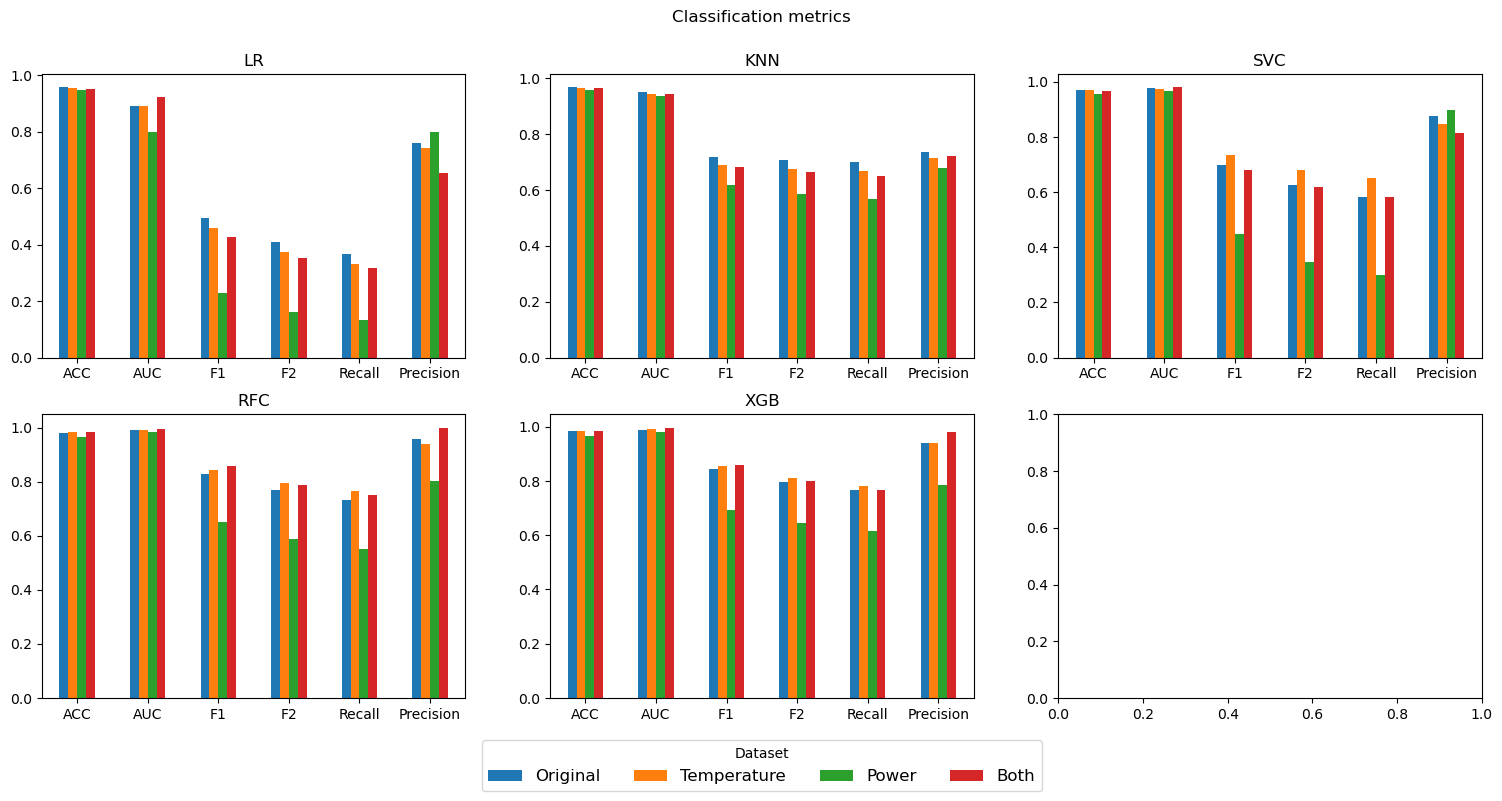

In [10]:
# Models
lr = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
xgb = XGBClassifier() 

clf = [lr,knn,svc,rfc,xgb]
clf_str = ['LR','KNN','SVC','RFC','XGB'] 

# Fit on raw train
XX_train = X_train.drop(columns=['temp_product','temp_difference','power_output'])
XX_val = X_val.drop(columns=['temp_product','temp_difference','power_output'])
metrics_0 = fit_models(clf, clf_str, XX_train, XX_val, y_train, y_val)

# Fit on temperature product and difference train
XX_train = X_train.drop(columns=['Process temperature _K_','Air temperature _K_','power_output'])
XX_val = X_val.drop(columns=['Process temperature _K_','Air temperature _K_','power_output'])
metrics_1 = fit_models(clf, clf_str, XX_train, XX_val, y_train, y_val)

# Fit on power product train
XX_train = X_train.drop(columns=['Rotational speed _rpm_','Torque _Nm_','temp_product','temp_difference'])
XX_val = X_val.drop(columns=['Rotational speed _rpm_','Torque _Nm_','temp_product','temp_difference'])
metrics_2 = fit_models(clf, clf_str, XX_train, XX_val, y_train, y_val)

# Fit on both products train
# XX_train = X_train.drop(columns=['Process temperature _K_','Air temperature _K_','Rotational speed _rpm_','Torque _Nm_'])
# XX_val = X_val.drop(columns=['Process temperature _K_','Air temperature _K_','Rotational speed _rpm_','Torque _Nm_'])
metrics_3 = fit_models(clf, clf_str, X_train, X_val, y_train, y_val)

# classification metrics barplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
fig.suptitle('Classification metrics')
for j, model in enumerate(clf_str):
    ax = axs[j//3,j-3*(j//3)]
    model_metrics = pd.DataFrame(data=[metrics_0[model],metrics_1[model],metrics_2[model],metrics_3[model]])
    model_metrics.index = ['Original','Temperature','Power','Both']
    model_metrics.transpose().plot(ax=ax, kind='bar', rot=0, )
    ax.title.set_text(model)
    ax.get_legend().remove()
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
axs.flatten()[-2].legend(title='Dataset', loc='upper center',
                         bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=12)
plt.show()

From the results obtained, it is observe that all the models applied to the entire dataset(both), perform better than when they are applied to the ones created by reducing the number of features.

Validation set metrics:
ACC          0.950
AUC          0.922
F1           0.427
F2           0.353
Recall       0.317
Precision    0.655
dtype: float64
Test set metrics:
ACC          0.960
AUC          0.948
F1           0.559
F2           0.476
Recall       0.433
Precision    0.788
dtype: float64


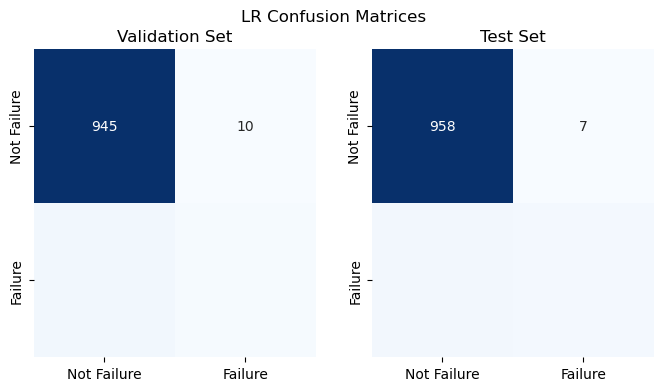

,feature,odds
3,Torque _Nm_,391.419520
2,Rotational speed _rpm_,9.921052
4,Tool wear _min_,2.535053
6,temp_difference,2.039691
0,Air temperature _K_,1.257644
5,temp_product,1.055981
1,Process temperature _K_,0.841972
7,power_output,0.053459


In [11]:
# Make predictions
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'binary')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'binary')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_labels = ['Not Failure', 'Failure']
cm_lr = [cm_val_lr, cm_test_lr]
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

# Odds for interpretation
d = {'feature': X_train.columns, 'odds': np.exp(lr.coef_[0])}
odds_df = pd.DataFrame(data=d).sort_values(by='odds', ascending=False)
odds_df

In [12]:
# Accessing confusion matrix elements for validation data

tn, fp, fn, tp = confusion_matrix(y_val, y_val_lr).ravel()

# Printing confusion matrix elements
print("True Negatives val:", tn)
print("False Positives val:", fp)
print("False Negatives val:", fn)
print("True Positives val:", tp)

# Accessing confusion matrix elements for test data

tn, fp, fn, tp = confusion_matrix(y_test, y_test_lr).ravel()

# Printing confusion matrix elements
print("True Negatives test", tn)
print("False Positives test:", fp)
print("False Negatives test:", fn)
print("True Positives test", tp)

True Negatives val: 945
False Positives val: 10
False Negatives val: 41
True Positives val: 19
True Negatives test 958
False Positives test: 7
False Negatives test: 34
True Positives test 26


The odds of logistic regression allow us to understand how the model is working. In particular, an unrealistically high importance is given to Torque and Rotational Speed. This is mainly due to the natural variance in these features, which is especially high when looking only at the failure cases and tends to "deviate" the model. However it is reasonable to believe, on the basis of exploratory analysis, that the first four features have a significantly greater relevance. 

In [13]:
# Models
knn = KNeighborsClassifier()
svc = SVC()
rfc = RandomForestClassifier()
xgb = XGBClassifier() 
clf = [knn,svc,rfc,xgb]
clf_str = ['KNN','SVC','RFC','XGB']

# Parameter grids for GridSearch
knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[300,500,700],
              'max_depth':[5,7],
              'learning_rate':[0.01,0.1],
              'objective':['binary:logistic']}
params = pd.Series(data=[knn_params,svc_params,rfc_params,xgb_params],
                   index=clf)

# Tune hyperparameters with GridSearch (estimated time 8m)
print('GridSearch start')
fitted_models_binary = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'binary')
    fitted_models_binary.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 18s
Training SVC
Best params: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 4m 18s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 300, 'random_state': 0}
Training time: 10m 53s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700, 'objective': 'binary:logistic'}
Training time: 5m 18s


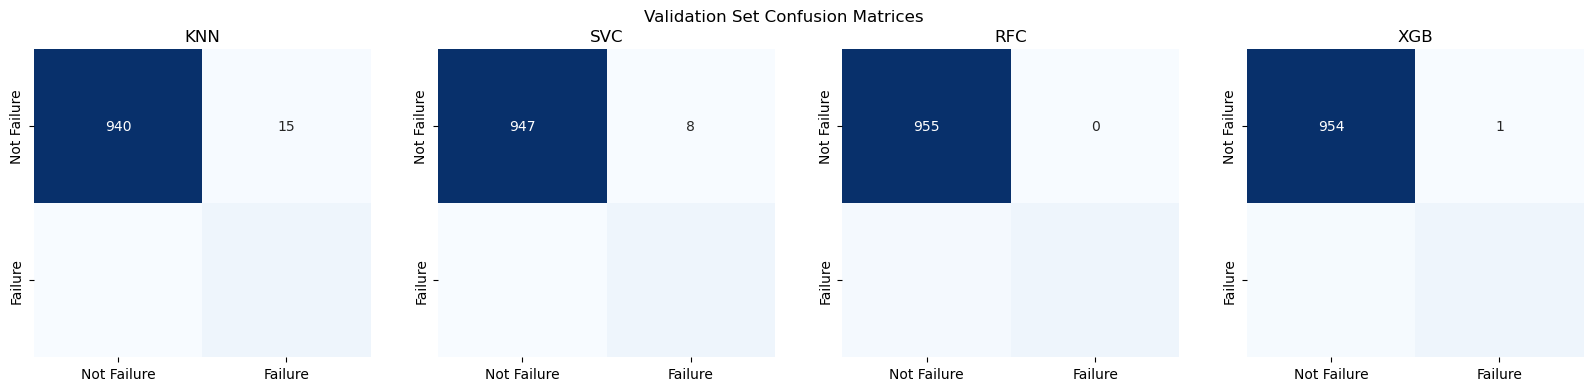

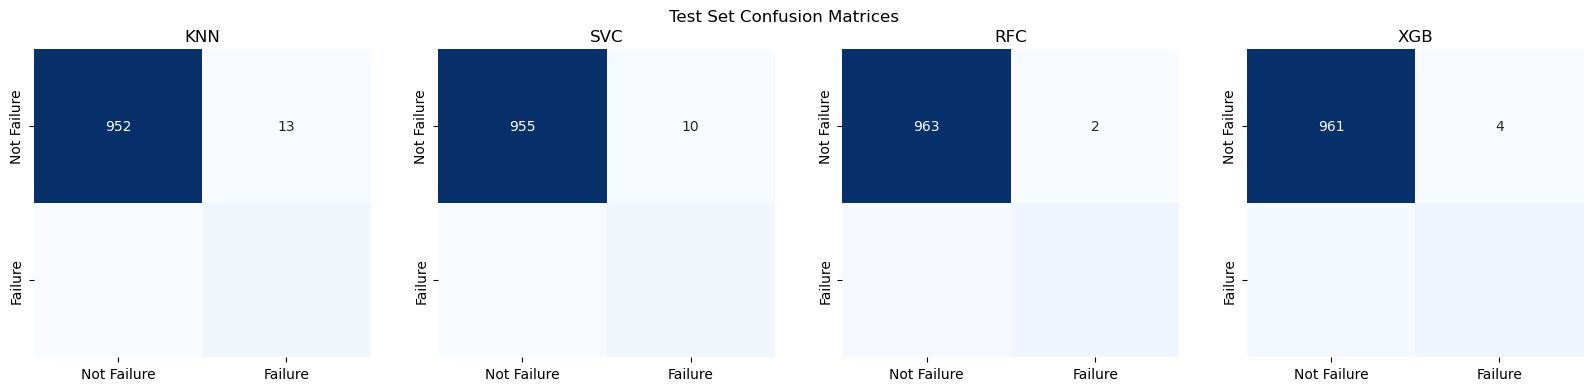


Validation scores:
       ACC    AUC     F1     F2  Recall  Precision
KNN  0.975  0.909  0.800  0.820   0.833      0.769
SVC  0.981  0.985  0.838  0.825   0.817      0.860
RFC  0.984  0.994  0.846  0.775   0.733      1.000
XGB  0.988  0.996  0.891  0.845   0.817      0.980
Test scores:
       ACC    AUC     F1     F2  Recall  Precision
KNN  0.977  0.902  0.803  0.811   0.817      0.790
SVC  0.979  0.990  0.814  0.805   0.800      0.828
RFC  0.983  0.997  0.841  0.784   0.750      0.957
XGB  0.984  0.996  0.857  0.822   0.800      0.923


In [14]:
# Create evaluation metrics
task = 'binary'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_binary,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_binary,X_test,y_test,clf_str,task)

# Show Validation Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

### RESULT SUMMARY
All the selected models obtain similar results on the validation set (except `KNN` and `SVC` which are pretty worse), and it is difficult to determine if one works better than another by looking only at these values. `Performance` did not significantly drop when passing the test set, showing that overfitting was avoided.  I comment on the results of the models by looking at the `confusion matrices` and the `metrics` obtained on the test set: in this way, the formation of a hierarchy between the models used is slightly clearer, as all the metrics relating to a single model are smaller or larger than to the others and the time needed to search for the parameters is comparable, with the only exception of `KNN`. In particular `KNN` obtains the worst performances and XGB the best ones; in the middle we find SVC and RFC which achieve extremely diffrent results also, where RFC is better.

### About the parameters:

A Gridsearch has been started on the parameters which, looking in the literature, appear to be preponderant for each specific model;
The grid values to search for have been defined on the basis of literature and various tests, trying to keep the computational cost of finding the best values moderate.
It is interesting to observe that the optimal parameters for `RFC` and `XGB` are the polar opposite: the former prefers to use a few estimators and go into depth while the latter uses more estimators with fewer splits. In any case, to get an idea of which features had greater importance in making the predictions, we report the permutation feature importances in a bar plot.

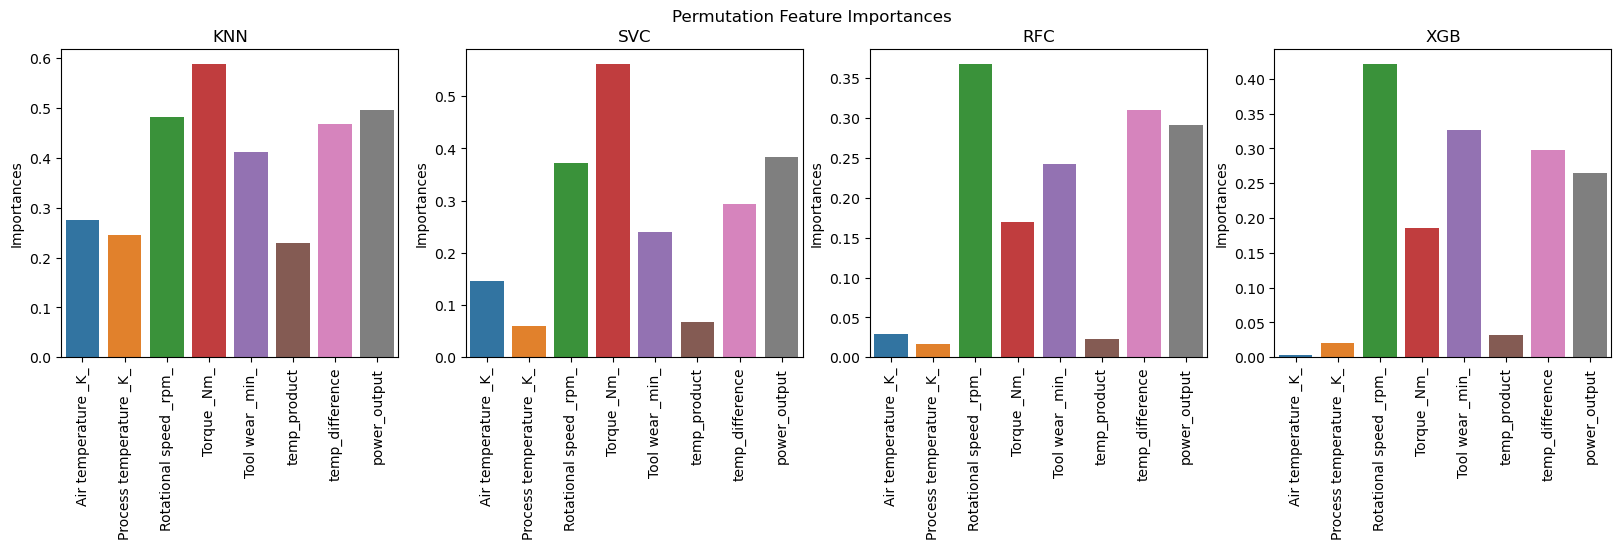

In [15]:
# Evaluate Permutation Feature Importances
f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
importances = pd.DataFrame()
for clf in fitted_models_binary:
    result = permutation_importance(clf, X_train,y_train,
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)
importances.columns = clf_str

# Barplot of Feature Importances
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()

### Remarks on Feature importances:

air and process temprature  are the features with the lowest significance, also in accordance with what was observed during the exploratory analysis. However, their importance remains strictly positive in each of the cases considered and therefore removing them completely would have led to a decline in prediction performance, not justified by a significant computational gain;

Unlike Logistic Regression and Support vector, the models tested place great emphasis on Rotational speed as well as Tool wear, power output and temperature difference.

## Summary

In this notebook, I explored various machine learning models for binary classification in the context of predicting equipment failures in an industrial setting. I trained Logistic Regression, K-Nearest Neighbors (KNN), Support Vector Classifier (SVC), Random Forest Classifier (RFC), and XGBoost Classifier (XGB) models. my analysis focused on understanding model performance under different feature subsets and evaluating their effectiveness on both validation and test datasets.

Initially, I trained the models on different subsets of features, including variations based on temperature and power-related variables. Despite observing minor fluctuations in model performance across these feature subsets, all models performed better when trained on the entire dataset compared to reduced feature sets.

Subsequently, I evaluated the best-performing model, `Random Forest and XG-boost`, on the validation and test sets. They exhibited robust performance, achieving high accuracy, area under the curve (AUC), and balanced precision and recall scores on both datasets. Confusion matrices provided insights into the model's ability to correctly classify failure and non-failure instances, with relatively low false positive and false negative rates.

Additionally, odds ratios derived from the Logistic Regression model shed light on the relative importance of individual features. While certain features such as Torque and Rotational Speed exhibited high odds ratios, suggesting their significant impact on predictions, others like Air and Process Temperature showed lower significance but remained positively associated with the target variable.

Furthermore, I employed grid search to optimize hyperparameters for KNN, SVC, RFC, and XGB models. Despite varying optimal parameter configurations, all models demonstrated competitive performance on the test set, indicating effective generalization and mitigating overfitting concerns.

In summary, my analysis underscores the suitability of `Random Forest and XG-boost` for the given classification task, with strong performance validated across multiple metrics and datasets. The grid search for hyperparameter optimization provided valuable insights into model parameter preferences, while feature importance analysis highlighted key predictors influencing failure predictions in the industrial context. Overall, the selected models offer promising capabilities for real-world deployment, subject to further validation and fine-tuning as needed.

## Save the model

In [16]:
import joblib

# Save the best RFC model
rfc_best_model = fitted_models_binary[2]  # Assuming RFC was the best-performing model
joblib.dump(rfc_best_model, r'C:\Users\USER\Documents\Python Scripts\Machine learning\Neural networks\Predictive Maintenance\predictive-maintenance-supervised-learning\models\best_rfc_model_mf.pkl')

# Save the best XGB model
xgb_best_model = fitted_models_binary[3]  # Assuming XGB was the best-performing model
joblib.dump(xgb_best_model, r'C:\Users\USER\Documents\Python Scripts\Machine learning\Neural networks\Predictive Maintenance\predictive-maintenance-supervised-learning\models\best_xgb_model_mf.pkl')


['C:\\Users\\USER\\Documents\\Python Scripts\\Machine learning\\Neural networks\\Predictive Maintenance\\predictive-maintenance-supervised-learning\\models\\best_xgb_model_mf.pkl']